# Diffusers实战

本章涵盖的知识点如下：
- 学习如何使用一个功能强大的自定义扩散模型管线(pipeline)，并了解如何独立制作一个新版本。
- 通过以下方式创建自己的迷你管线：
    - 复习扩散模型的核心概念
    - 从 Hugging Face Hub中加载数据以进行训练
    - 探索如何使用调度器将噪声添加到数据中
    - 创建并训练一个UNet网络模型
    - 将各个模块组合在一起，形成一个工作管线(working pipeline)
- 编写并执行一段代码，以初始化一个时间较长的训练过程，这段代码涉及以下处理环节：
    - 使用Accelerate库调用多个GPU以加快模型的训练过程
    - 记录并查阅实验日志以跟踪关键统计数据
    - 将最终模型上传到Hugging Face Hub

## 1. 环境准备

### 1.1 安装Diffusers库

首先安装包括Diffusers库在内的第三方库：

```bash
pip install diffusers datasets transformers accelerate fifty pyarrow
```

然后访问 https://huggingface.co/settings/tokens ，创建具有write权限的访问令牌

你可以通过命令行使用创建的访问令牌来登陆(huggingface-cli login)，也可以通过运行以下代码来登陆：

In [1]:
from huggingface_hub import notebook_login

#notebook_login()

/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from huggingface_hub import whoami

print(whoami())

{'type': 'user', 'id': '679973b8625629080bddab3e', 'name': 'Hasson827624', 'fullname': 'Zhao Hongshuo', 'email': 'hz108@illinois.edu', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': '/avatars/62a15052bc706dffff00e7413024ef2a.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'Diffusion-Learning', 'role': 'write', 'createdAt': '2025-02-22T17:34:15.686Z'}}}


接下来，你需要安装 Git LFS以上传模型检查点：(MacOS用户建议在终端中运行以下命令：)
```bash
brew install git-lfs
git lfs install
```

然后回到vscode终端后检查
```bash
git lfs --version
```

In [3]:
'''
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store
'''

'\n%%capture\n!sudo apt -qq install git-lfs\n!git config --global credential.helper store\n'

最后，导入将要使用的库并定义一些简单的支持函数：

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
    """
    给定一批图像,创建一个网格并将其转换为PIL
    """
    x = x*0.5+0.5 # 将(-1,1)区间映射回(0,1)区间
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def make_grid(images,size=64):
    """
    给定一个PIL图像列表,将他们叠加成一行便于查看
    """
    output_im = Image.new("RGB",(size*len(images),size))
    for i,im in enumerate(images):
        output_im.past(im.resize((size,size)),(i*size,0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.mps.is_available
                      else "cpu")

### 1.2 DreamBooth

你一定听说过稳定扩散模型(Stable Diffusion Model)，这是一个功能强大的图像生成模型，但它也有局限性：除非互联网上包含大量我们的照片，否则它无法识别你我长什么样。

然而，DreamBooth能让我们对稳定扩散模型进行微调，并在整个过程中引入特定的面部、物体或风格的额外信息。

首先让我们加载这个管线：

In [5]:
from diffusers import StableDiffusionPipeline

# https://huggingface.co/sd-dreambooth-library 中有来自社区的各种模型
model_id = "sd-dreambooth-library/mr-potato-head"
# 你可以前往 https://huggingface.co/sd-dreambooth-library/mr-potato-head 查看

# 加载管线
pipe = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


以上代码会自动从Hugging Face Hub下载模型权重等需要的文件。

管线加载完之后，使用以下代码即可生成示例图像：

  0%|          | 0/50 [00:00<?, ?it/s]

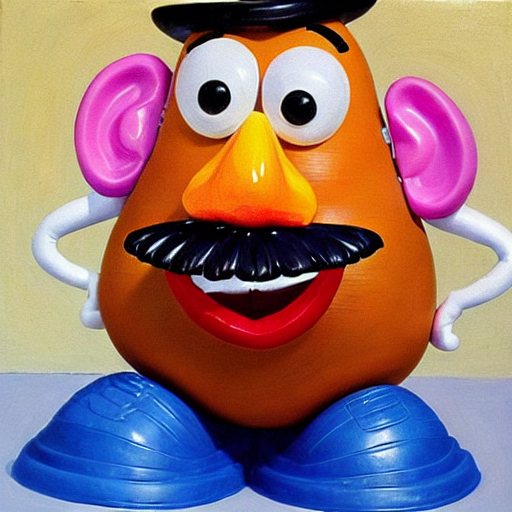

In [6]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt,num_inference_steps=50,guidance_scale=7.5).images[0]
image

**参数说明：**

- `sks`是新引入的唯一标识符(Unique IDentifier, UID)，尝试将其留空，看看会发生什么？
- `num_inference_steps`代表采样步骤的数量
- `guidance_scale`决定模型的输出与提示语之间的匹配程度

通过调整这些参数，你可以进一步探索模型的行为和性能

### 1.3 Diffusers核心API

Diffusers核心API主要分为三个部分：

- 管线：从高层次设计的多种类函数，旨在便于部署的方式实现，能够快速地利用与训练好的主流扩散模型来生成样本
- 模型：在训练新的扩散模型时需要用到的网络结构，如UNet网络模型
- 调度器：在推理过程中使用多种不同的技巧来从噪声中生成图像，同时也可以生成训练过程中所需的“带噪”图像

到目前为止，训练扩散模型的流程如下：

1. 从训练集中加载图像
2. 添加不同级别的噪声
3. 将添加了不同级别噪声的数据输入模型
4. 评估模型对这些输入去噪的效果
5. 使用得到的性能信息更新模型权重，然后重复上述步骤

接下来将逐步完成上述步骤，直至训练循环能够完整运行

## 2. 实战：生成美丽的蝴蝶图像
### 2.1 下载蝴蝶图像集

接下来我们将下载一个来自Hugging Face Hub的包含1000幅蝴蝶图像的数据集。这其实是一个很小的数据集。

In [30]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset",split="train")

# 在 32*32 像素的正方形图像上进行训练，你也可以尝试更大尺寸
image_size = 32
batch_size = 64

# 定义数据增强过程
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)), # 调整大小
    transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.ToTensor(), # 将图像转变为 (0,1) 区间内的张量
    transforms.Normalize([0.5],[0.5]) # 将张量映射到 (-1,1) 区间
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images":images}

dataset.set_transform(transform)

# 创建一个数据加载器，用于批量提供经过变换的图像
train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.


我们可以从中取出一批图像数据并进行可视化：

X shape: torch.Size([8, 3, 32, 32])


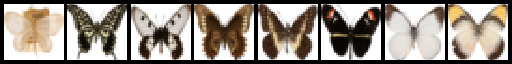

In [31]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8*64,64),resample = Image.NEAREST)

### 2.2 扩散模型之调度器
在训练扩散模型的过程中，我们需要获取这些输入图像并为他们添加噪声，然后将“带噪”的图像输入模型。在推理阶段，我们将使用模型的预测结果逐步消除这些噪声。在扩散模型中，这两个步骤是由调度器(scheduler)处理的。

噪声调度器能够确定在不同迭代周期分别添加多少噪声。接下来我们将学习如何使用DDPM训练和采样的默认设置来创建调度程序。

In [32]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

**练习:** 我们可以通过设置beta_start、beta_end 和 beta_schedul 3个参数来控制噪声调度器的超参数beta，beta_start为控制推理阶段开始时beta的值，beta_end为控制beta的最终值，beta_schedule则可以通过一个函数映射来为模型推理的每一步生成一个beta值。

从以下两个调度器代码中选择一个，探索一下使用不同的参数值时曲线是如何变化的。

In [33]:
# 仅添加了少量噪声
noise_scheduler_1 = DDPMScheduler(num_train_timesteps=1000,beta_start=1e-3,beta_end=4e-3)
# “cosine”调度方式，这种方式可能更适合尺寸较小的图像
noise_scheduler_2 = DDPMScheduler(num_train_timesteps=1000,beta_schedule='squaredcos_cap_v2')

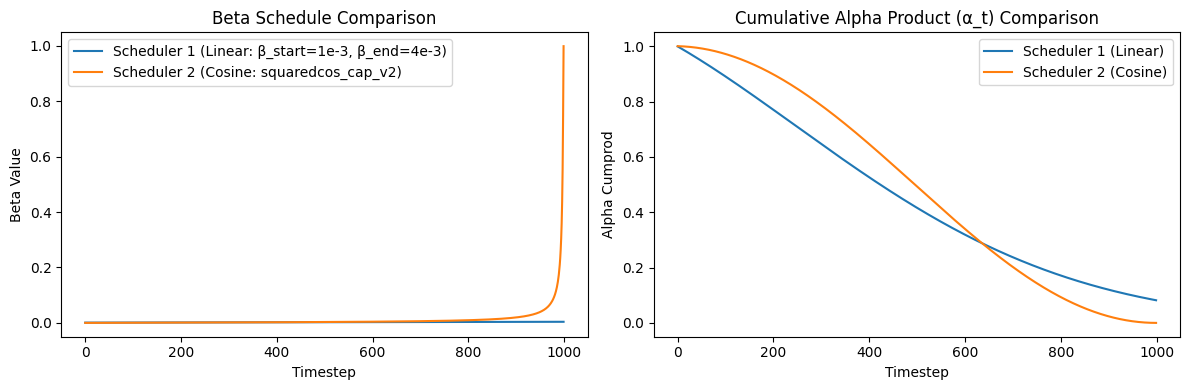

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6508976..1.094781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.604032..1.0232073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3002201..1.9286761].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9270741..1.5853951].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6942062..2.4467773].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2205588..1.9878786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.017384..

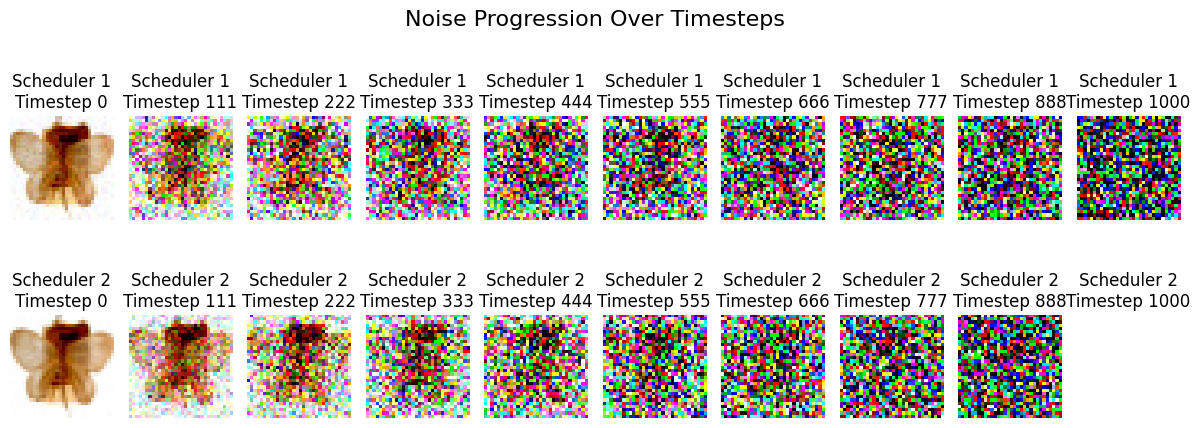

In [36]:
# 
def visualize_schedulers_comparison(scheduler1, scheduler2, timesteps=1000):
    """
    可视化两个 DDPMScheduler 调度器在 beta 分布、alpha 累积产品和噪声添加效果上的差异。

    Args:
        scheduler1: 第一个 DDPMScheduler 实例
        scheduler2: 第二个 DDPMScheduler 实例
        timesteps: 时间步数量，默认 1000
    """
    # 准备调度器
    scheduler1.set_timesteps(timesteps)
    scheduler2.set_timesteps(timesteps)

    # 提取 beta 和 alpha_cumprod
    betas_1 = scheduler1.betas.cpu().numpy()
    alphas_cumprod_1 = scheduler1.alphas_cumprod.cpu().numpy()

    betas_2 = scheduler2.betas.cpu().numpy()
    alphas_cumprod_2 = scheduler2.alphas_cumprod.cpu().numpy()

    # 绘制 beta 分布
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(betas_1, label='Scheduler 1 (Linear: β_start=1e-3, β_end=4e-3)')
    plt.plot(betas_2, label='Scheduler 2 (Cosine: squaredcos_cap_v2)')
    plt.title('Beta Schedule Comparison')
    plt.xlabel('Timestep')
    plt.ylabel('Beta Value')
    plt.legend()

    # 绘制 alpha_cumprod
    plt.subplot(1, 2, 2)
    plt.plot(alphas_cumprod_1, label='Scheduler 1 (Linear)')
    plt.plot(alphas_cumprod_2, label='Scheduler 2 (Cosine)')
    plt.title('Cumulative Alpha Product (α_t) Comparison')
    plt.xlabel('Timestep')
    plt.ylabel('Alpha Cumprod')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 🔥 **可视化相同样本在不同时间步下的噪声效果**
    # 从样本中找一个拿来可视化
    sample = xb[0].unsqueeze(0)
    timesteps_to_show = []
    for i in np.linspace(0,1,10):
        timesteps_to_show.append(int(timesteps*i))
    fig, axs = plt.subplots(2, len(timesteps_to_show), figsize=(12, 5))
    fig.suptitle("Noise Progression Over Timesteps", fontsize=16)

    for i, t in enumerate(timesteps_to_show):
        # 调用 scheduler 的 add_noise 方法
        noisy_1 = scheduler1.add_noise(sample, torch.randn_like(sample), torch.tensor([t]))
        noisy_2 = scheduler2.add_noise(sample, torch.randn_like(sample), torch.tensor([t]))

        # 绘制 Scheduler 1 的噪声效果
        axs[0, i].imshow(noisy_1[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axs[0, i].set_title(f"Scheduler 1\nTimestep {t}")
        axs[0, i].axis('off')

        # 绘制 Scheduler 2 的噪声效果
        axs[1, i].imshow(noisy_2[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axs[1, i].set_title(f"Scheduler 2\nTimestep {t}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_schedulers_comparison(noise_scheduler_1, noise_scheduler_2)


无论选择哪个调度器，我们现在都可以使用`noise_scheduler.add_noise` 为图片添加不同程度的噪声

Noisy X shape torch.Size([8, 3, 32, 32])


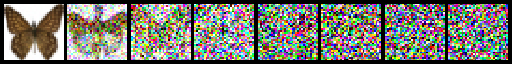

In [12]:
timesteps = torch.linspace(0,999,8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print('Noisy X shape',noisy_xb.shape)
show_images(noisy_xb).resize((8*64,64),resample=Image.NEAREST)

### 2.3 定义扩散模型
下面介绍本章的核心内容——模型。大多数扩散模型使用的模型结构是一些UNet网络模型的变体。简单来说，UNet网络模型的工作流程如下：
1. 输入UNet网络模型的图片会经过几个ResNet层中的标准网络模块，并且在经过每个标准网络模块后，图片的尺寸都将减半。
2. 同样数量的上采样层则能够将图片的尺寸恢复到原始尺寸。
3. 残差连接模块会将特征图分辨率相同的上采样层和下采样层连接起来。

UNet网络模型的一个关键特征是其输入图片的尺寸与输出图片的尺寸相同，而这正是我们在扩散模型中所需要的。

Diffusers 为我们提供了一个易用的UNet2DModel类，用于在PyTorch中创建需要的结构。

下面我们使用UNet网络模型生成具有目标尺寸的图片。注意，在下面的代码中，down_block_types对应下采样模块，up_block_types对应上采样模块。

In [ ]:
from diffusers import UNet2DModel

# 创建模型
model = UNet2DModel(
    sample_size = image_size, # 输入和输出图像的分辨率
    in_channels = 3, # 输入通道数，对于RGB通道来说，通道数为3
    out_channels = 3, # 输出通道数
    layers_per_block = 2, # 每个UNet块使用的ResNet层数
    block_out_channels = (64,128,128,256), # 更多的通道 -> 更多的参数
    down_block_types=(
        "DownBlock2D", # 一个常规的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D", # 一个带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", # 一个带有空间自注意力的ResNet上采样模块
        "AttnUpBlock2D",
        "UpBlock2D", # 一个常规的ResNet上采样模块
        "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

#### 模型参数理解
##### 1.`layers_per_block`对模型的影响
`layers_per_block` 参数定义了每个 U-Net 模块中使用的 ResNet 层数。在 UNet2DModel 中，每个块（block）通常包含以下部分：
- 卷积层
- 归一化层（如 `GroupNorm`）
- 非线性激活函数（如 `GELU` 或 `ReLU`）
- 残差连接（ `ResNet` 层）

**影响分析：**

1. 模型容量与表达能力
    - 更高的层数：每个 block 中的 ResNet 层越多，模型可以学习的特征表示越复杂，对细节和结构的建模能力更强。
    - 更低的层数：减少层数可以加快训练速度，但可能导致模型表达能力不足。
2. 训练稳定性
    - ResNet 层通过残差连接缓解了深层网络中的梯度消失问题。
    - 较多的 ResNet 层可以让模型训练更深的特征表示，同时保持训练过程稳定。
3. 计算资源消耗
    - 更多的 ResNet 层 = 更多的参数，会导致训练和推理时间增加，以及内存占用上升。

**`ResNet` 层在 U-Net 模块中的位置**

在 U-Net 架构中，每个 DownBlock 和 UpBlock 都包含多个 ResNet 层。一个典型的 U-Net 块的结构如下：

1. 下采样块 (DownBlock2D)
```plaintext
输入张量
   │
[ ResNet 层 1 ] ──► [ ResNet 层 2 ] ──► 下采样（如 stride=2 卷积）
   │
   └─ 残差连接（跳跃连接）

```

2. 上采样块 (UpBlock2D)
```plaintext
输入张量
   │
上采样（如转置卷积或上采样插值）
   │
[ ResNet 层 1 ] ──► [ ResNet 层 2 ] 
   │
   └─ 残差连接（与对称下采样块的输出拼接）

```

3. 在有注意力机制的块 (`AttnDownBlock2D` & `AttnUpBlock2D`)
```plaintext
输入张量
   │
[ ResNet 层 1 ] ──► [ ResNet 层 2 ] ──► 自注意力模块
   │
   └─ 残差连接

```

##### 2. `block_out_channels` 的含义与数量选择

**含义：**  
- `block_out_channels` 是一个元组，**定义了每个 U-Net 块的输出通道数**。  
- 每个元素对应一个下采样-上采样层级中的通道数。例如：  
  ```python
  block_out_channels = (64, 128, 128, 256)
  ```
  表示共有 4 个层级，通道数依次为 64 → 128 → 128 → 256。

**影响：**
- 更多层级：提取更深的特征，但增加计算开销。
- 更高通道数：提升表达能力，但消耗更多内存。
- 层级数量需与 `down_block_types` 和 `up_block_types` 数量匹配。

##### 3. 常规下/上采样层 vs. 带空间自注意力的下/上采样层
- 常规下/上采样层 (`DownBlock2D` / `UpBlock2D`)
   - 功能：主要通过卷积与池化（下采样）或反卷积/插值（上采样）操作进行特征维度转换。
   - 特征：
      - 侧重于局部特征提取。
      - 结构较轻，计算量较小。
- 带空间自注意力的下/上采样层 (`AttnDownBlock2D` / `AttnUpBlock2D`)
   - 功能：在下/上采样过程中引入空间自注意力机制，捕捉全局依赖关系。
   - 特征：
      - 能捕捉远距离像素之间的相关性，提升生成图像的全局一致性。
      - 计算量较大，更适用于复杂或高分辨率任务。

##### 4. ResNet 上/下采样模块的含义与 ResNet 关系
- 为什么称为“ResNet 上/下采样模块”？
   - 这些模块内部嵌入了 ResNet 层（残差连接 + 卷积层）。
   - 残差连接允许输入特征绕过卷积层直接与输出相加，从而：
      - ✅ 缓解深层网络中的梯度消失问题。
      - ✅ 提高训练稳定性和收敛速度。
- 具体区别
   - 常规模块：仅包含卷积与上/下采样操作。
   - ResNet 模块：在这些基础上添加了残差连接，使得模型能够在进行特征转换的同时，保留原始输入的关键信息。

##### 总结

| 参数/模块               | 功能                          | 影响                                   | 注意事项                                 |
|----------------------|-----------------------------|--------------------------------------|--------------------------------------|
| `block_out_channels` | 每个块的输出通道数                  | 更多通道数 → 更强表达力，但计算成本更高       | 数量需与 `down_block_types` 和 `up_block_types` 数量匹配 |
| `layers_per_block`   | 每个 U-Net 块中 ResNet 层的数量       | 更高的层数可以提升模型表达能力和训练稳定性，但会增加计算量 | 层数越多，模型的容量越大，训练过程越稳定，适合复杂任务 |
| 常规下/上采样层         | 局部特征提取、维度变换               | 快速高效，但缺乏全局上下文建模               | 适合低复杂度或实时任务                      |
| 自注意力下/上采样层      | 融合全局信息，捕捉远程依赖            | 提高生成一致性，但计算量大                  | 适合高分辨率或复杂生成任务                  |
| ResNet 上/下采样模块    | 通过残差连接提升训练稳定性与深层特征提取 | 避免梯度消失，提高模型深度训练能力           | ResNet 层数可通过 `layers_per_block` 调整   |


在完成模型的定义后，我们可以通过输入一批数据和随机的迭代周期数来看看输出尺寸与输入尺寸是否相同

In [14]:
with torch.inference_mode():
    model_prediction = model(noisy_xb,timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

### 2.4 创建扩散模型训练循环
每次数据的训练流程如下：
1. 随机地采样几个迭代周期
2. 对数据进行相应的噪声处理
3. 把“带噪”数据输入模型
4. 将MSE作为损失函数，比较目标结果与模型的预测结果。也就是比较真实噪声和模型预测的噪声时间的差距
4. 通过调用函数 `loss.backward()` 和 `optimizer.step()` 来更新模型参数

在这个过程中，我们需要记录每一步中损失函数的值，用于绘制后续损失函数曲线

Epoch 5 | loss: 0.8328818678855896
Epoch 10 | loss: 0.8328255154192448
Epoch 15 | loss: 0.8333551287651062
Epoch 20 | loss: 0.8329600691795349
Epoch 25 | loss: 0.8330240100622177
Epoch 30 | loss: 0.8330377005040646


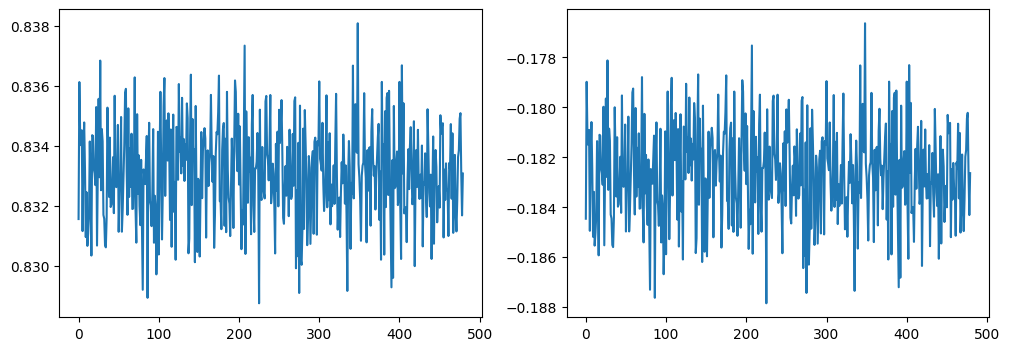

In [ ]:
# 设定噪声数据
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,beta_schedule="squaredcos_cap_v2")

# 训练循环
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-6)
loss_fn = nn.L1Loss()
losses = []

for epoch in range(30):
    for _,batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        model.train()

        
        #为图片添加采样噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        
        # 为每张图片随机采样一个时间步
        timesteps = torch.randint(0,noise_scheduler.config.num_train_timesteps,(bs,),device = clean_images.device).long()
        
        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images,noise,timesteps)
        
        # 获得模型的预测结果
        noise_pred = model(noisy_images,timesteps,return_dict=False)[0]
        
        # 反向传播，更新参数
        loss = loss_fn(noise_pred,noise)
        loss.backward()
        losses.append(loss.item())
        optimizer.zero_grad()
        optimizer.step()
        
    if (epoch+1)%5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):])/len(train_dataloader)
        print(f"Epoch {epoch+1} | loss: {loss_last_epoch}")
    
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### 2.5 图像的生成
接下来的问题是：我们应该如何通过这个模型来生成图像呢？方法有两种

1. 建立一个管线

  0%|          | 0/1000 [00:00<?, ?it/s]

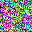

In [16]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model,scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

输入以下代码，将管线保存到本地文件夹中：

In [17]:
image_pipe.save_pretrained("my_pipeline")

你会得到一个文件夹名为`my_pipeline`，其中有`scheduler`和`unet`子文件夹，包含了生成图像所需的全部组件。unet文件夹中有`config.json`和`diffusion_pytorch_model.safetensors`两个文件，你可以手动将这两个文件上传到Hugging Face Hub，或使用API来实现这个操作

2. 建立一个采样循环

你可以检查一下管线中的forward方法(`image_pipe.forward`)，并尝试理解运行image_pipe时发生了什么。

我们从完全随机的“带噪”图像开始，从最大噪声往最小噪声方向运行调度器，并根据模型每一步的预测去除少量噪声

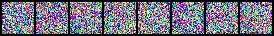

In [18]:
# 随机初始化（8张随机噪声）
sample = torch.randn(8,3,32,32).to(device)

for i,t in enumerate(noise_scheduler.timesteps):
    
    # 获得模型的预测结果
    with torch.inference_mode():
        residual = model(sample,t).sample
    
    # 根据预测结果更新图像
    sample = noise_scheduler.step(residual,t,sample).prev_sample

show_images(sample)

## 3. 拓展知识
### 3.1 将模型上传到Hugging Face Hub
如果想要把自己训练的模型推送到Hugging Face Hub，那么你需要将文件推送到模型储存库。Hugging Face Hub将根据你的选择（模型ID）来决定模型存储库的名称（你可以自由更改model_name，它只需要包含用户名即可，这正是`get_full_repo_name()`函数所要完成的操作）

In [19]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Hasson827624/sd-class-butterflies-32'

接下来，我们在Hugging Face Hub上创建一个模型仓库并将其上传。

In [21]:
from huggingface_hub import HfApi,create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path = "my_pipeline/scheduler",
    path_in_repo = "",
    repo_id = hub_model_id
)
api.upload_folder(
    folder_path = "my_pipeline/unet",
    path_in_repo = "",
    repo_id = hub_model_id
)
api.upload_file(
    path_or_fileobj = "my_pipeline/model_index.json",
    path_in_repo = "model_index.json",
    repo_id = hub_model_id
)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hasson827624/sd-class-butterflies-32/commit/0a79ee2726fa68022a3f799c136b909a62a134db', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='0a79ee2726fa68022a3f799c136b909a62a134db', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Hasson827624/sd-class-butterflies-32', endpoint='https://huggingface.co', repo_type='model', repo_id='Hasson827624/sd-class-butterflies-32'), pr_revision=None, pr_num=None)

最后，我们还可以通过以下代码船舰一个精美的模型卡片

In [28]:
from huggingface_hub import ModelCard

content = """
---
license: mit
tags:
  - pytorch
  - diffusers
  - unconditional-image-generation
  - diffusion-models-class
---
# 这个模型用于生成蝴蝶图像的无条件图像生成扩散模型

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained("Hasson827624/sd-class-butterflies-32")
image = pipeline().images[0]
image
"""

card = ModelCard(content) 
card.push_to_hub(hub_model_id)


CommitInfo(commit_url='https://huggingface.co/Hasson827624/sd-class-butterflies-32/commit/1598a63d7da318187129447e76d7729af2505c00', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='1598a63d7da318187129447e76d7729af2505c00', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Hasson827624/sd-class-butterflies-32', endpoint='https://huggingface.co', repo_type='model', repo_id='Hasson827624/sd-class-butterflies-32'), pr_revision=None, pr_num=None)